In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import random
import re
import os
import tempfile
import cv2
import numpy as np
import imageio
from IPython import display
from urllib import request

from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
logging.set_verbosity(logging.ERROR)

In [ ]:
# Utilities to fetch videos from UCF101 dataset
class UCF101Dataset():
  def __init__(self):
    self.UCF_ROOT = "http://crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
    self._VIDEO_LIST = None
    self._CACHE_DIR = tempfile.mkdtemp()
    
  def list_ucf_videos(self):
    # Lists available videos in UCF101 dataset.
    if not self._VIDEO_LIST:
      index = request.urlopen(self.UCF_ROOT).read().decode("utf-8")
      videos = re.findall("(v_[\w_]+\.avi)", index)
      self._VIDEO_LIST = sorted(set(videos))
    return list(self._VIDEO_LIST)

  def fetch_ucf_video(self, video):
    # Fetchs a video and cache into local filesystem.
    cache_path = os.path.join(self._CACHE_DIR, video)
    
    if not os.path.exists(cache_path):
      urlpath = request.urljoin(self.UCF_ROOT, video)
      print("Fetching %s => %s" % (urlpath, cache_path))
      data = request.urlopen(urlpath).read()
      open(cache_path, "wb").write(data)
    return cache_path

  def crop_center_square(self, frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

  def load_video(self, path, max_frames=0, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
      while True:
        ret, frame = cap.read()
        if not ret:
          break
        frame = self.crop_center_square(frame)
        frame = cv2.resize(frame, resize)
        frame = frame[:, :, [2, 1, 0]]
        frames.append(frame)
        
        if len(frames) == max_frames:
          break
    finally:
      cap.release()
    return np.array(frames) / 255.0

  def to_gif(self, images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=25)
    return embed.embed_file('./animation.gif')

In [ ]:
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


In [ ]:
# Get the list of videos in the dataset.
ucf = UCF101Dataset()
ucf_videos = ucf.list_ucf_videos()
  
categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))

Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              


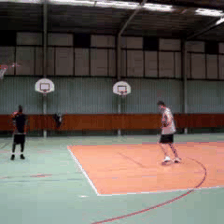

In [ ]:
# Get a sample cricket video.
video_path = ucf.fetch_ucf_video("v_Basketball_g01_c01.avi")
sample_video = ucf.load_video(video_path)
ucf.to_gif(sample_video)

In [ ]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [ ]:
def predict(sample_video):
  # Add a batch axis to the to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:8]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [ ]:
predict(sample_video)

Top 5 actions:
  shooting basketball   : 48.53%
  playing badminton     : 21.77%
  dribbling basketball  : 13.18%
  playing tennis        :  7.37%
  playing volleyball    :  4.26%
  catching or throwing softball:  2.09%
  playing basketball    :  1.16%
  catching or throwing baseball:  0.85%
